In [8]:
import pandas as pd
import pyomo.environ as pe
import pyomo.gdp as pyogdp
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pdb
from matplotlib.ticker import MaxNLocator
from itertools import product
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [9]:
model = pe.ConcreteModel()
case_path = os.path.join(os.path.dirname(os.getcwd()), "data", "gantt.csv")
session_path = os.path.join(os.path.dirname(os.getcwd()), "data", "sessions_mda.csv")
options = {"seconds": 10000}

In [11]:
df = pd.read_csv(case_path)
df=df.assign(CaseID=range(len(df)))
df['Scheduled Setup Start']=pd.to_datetime(df['Scheduled Setup Start'])
df['Scheduled Cleanup Complete']=pd.to_datetime(df['Scheduled Cleanup Complete'])
df['Scheduled Room Duration']=(df['Scheduled Cleanup Complete']-df['Scheduled Setup Start']).astype('timedelta64[m]')
# df['Room']=df.apply(lambda row: int(row['Room'][-2:]), axis = 1)
df['Room']=df.apply(lambda row: int(re.search(r'\d+', row['Room']).group()), axis = 1)
df['SurgeonID'] = df.groupby('Primary Surgeon Name').ngroup()

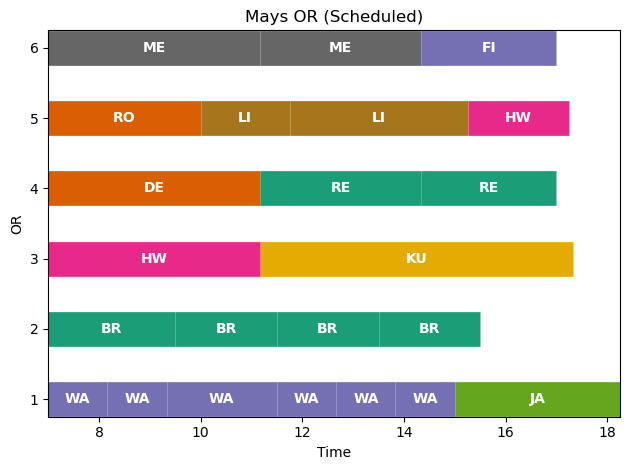

In [12]:
sessions = sorted(list(df['Room'].unique()))

bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
colors = cm.Dark2.colors

fig, ax = plt.subplots(1, 1)

for s_ix, s in df.iterrows():
    xs = s['Scheduled Setup Start'].hour + s['Scheduled Setup Start'].minute/60
    xf = s['Scheduled Cleanup Complete'].hour + s['Scheduled Cleanup Complete'].minute/60
    ax.plot([xs, xf], [s['Room']] * 2, c=colors[s['SurgeonID']%len(colors)], **bar_style)
    ax.text((xs + xf) / 2, s['Room'], s['Primary Surgeon Name'][:2], **text_style)

ax.set_title('Mays OR (Scheduled)')
# ax.set_title('Mays OR (Actual)')
ax.set_xlabel('Time')

ax.set_ylabel('OR')
# ax.grid(True)
ax.set_xlim([7, 18.25])

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()
plt.show()

In [3]:
class TheatreScheduler:
    def __init__(self, case_file_path, session_file_path):
        """
        Read case and session data into Pandas DataFrames
        Args:
            case_file_path (str): path to case data in CSV format
        """
        try:
            self.df_cases = pd.read_csv(case_file_path)
            self.df_cases_g = pd.DataFrame()
        except FileNotFoundError:
            print("Case data not found.")
        self.df_cases=self.df_cases.assign(CaseID=range(len(self.df_cases)))
        self.df_cases['Scheduled Setup Start']=pd.to_datetime(self.df_cases['Scheduled Setup Start'])
        self.df_cases['Scheduled Cleanup Complete']=pd.to_datetime(self.df_cases['Scheduled Cleanup Complete'])
        self.df_cases['Scheduled Room Duration']=(self.df_cases['Scheduled Cleanup Complete']-self.df_cases['Scheduled Setup Start']).astype('timedelta64[m]')
#         self.df_cases['Room']=self.df_cases.apply(lambda row: int(row['Room'][-2:]), axis = 1)
        self.df_cases['Room']=df.apply(lambda row: int(re.search(r'\d+', row['Room']).group()), axis = 1)
        self.df_cases['SurgeonID'] = self.df_cases.groupby('Primary Surgeon Name').ngroup()
        self.df_cases_g = self.df_cases.groupby('Primary Surgeon Name')['Scheduled Room Duration'].sum().reset_index()
        self.df_cases_g['CaseID'] = self.df_cases.groupby('Primary Surgeon Name')['CaseID'].min().reset_index()['CaseID'].to_dict()
        self.df_cases_g['SurgeonID'] = self.df_cases_g['CaseID']
        try:
            self.df_sessions = pd.read_csv(session_file_path)
        except FileNotFoundError:
            print("Session data not found")
        self.model = self.create_model()
    
    def _generate_case_durations(self):
        """
        Generate mapping of cases IDs to median case time for the procedure
        Returns:
            (dict): dictionary with CaseID as key and median case time (mins) for procedure as value
        """
        return pd.Series(self.df_cases["Scheduled Room Duration"].values, index=self.df_cases["CaseID"]).to_dict()
#         return pd.Series(self.df_cases_g["Scheduled Room Duration"].values, index=self.df_cases_g["CaseID"]).to_dict()

    def _generate_session_durations(self):
        """
        Generate mapping of all theatre sessions IDs to session duration in minutes
        Returns:
            (dict): dictionary with SessionID as key and session duration as value
        """
        return pd.Series(self.df_sessions["Duration"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_session_start_times(self):
        """
        Generate mapping from SessionID to session start time
        Returns:
            (dict): dictionary with SessionID as key and start time in minutes since midnight as value
        """
        # Convert session start time from HH:MM:SS format into seconds elapsed since midnight
        self.df_sessions.loc[:, "Start"] = pd.to_timedelta(self.df_sessions["Start"])
        self.df_sessions.loc[:, "Start"] = self.df_sessions["Start"].dt.total_seconds() / 60
        return pd.Series(self.df_sessions["Start"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _get_ordinal_case_deadlines(self):
        """
        #TODO
        Returns:

        """
        self.df_cases.loc[:, "Case Expected Date"] = pd.to_datetime(self.df_cases["Case Expected Date"])
        self.df_cases.loc[:, "Case Expected Date"] = self.df_cases["Case Expected Date"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_cases["Case Expected Date"].values, index=self.df_cases["CaseID"]).to_dict()
#         return pd.Series(self.df_cases["Case Expected Date"].values, index=self.df_cases_g["CaseID"]).to_dict()
    
    def _get_case_surgeon(self):
        """
        #TODO
        Returns:

        """
        self.df_cases.loc[:, "SurgeonID"] = self.df_cases_g["SurgeonID"]
        return pd.Series(self.df_cases_g["SurgeonID"].values, index=self.df_cases_g["CaseID"]).to_dict()
    
    def _get_ordinal_session_dates(self):
        """
        #TODO
        Returns:

        """
        self.df_sessions.loc[:, "Date"] = pd.to_datetime(self.df_sessions["Date"])
        self.df_sessions.loc[:, "Date"] = self.df_sessions["Date"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_sessions["Date"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_disjunctions(self):
        """
        #TODO
        Returns:
            disjunctions (list): list of tuples containing disjunctions
        """
        cases = self.df_cases["CaseID"].to_list()
#         cases = self.df_cases_g["CaseID"].to_list()
        sessions = self.df_sessions["SessionID"].to_list()
        disjunctions = []
        for (case1, case2, session) in product(cases, cases, sessions):
            if (case1 != case2) and (case2, case1, session) not in disjunctions:
                disjunctions.append((case1, case2, session))

        return disjunctions
    
    def _generate_disjunctions_sur(self):
        """
        #TODO
        Returns:
            disjunctions (list): list of tuples containing disjunctions
        """
        cases = self.df_cases["CaseID"].to_list()
#         cases = self.df_cases_g["CaseID"].to_list()
        sessions = self.df_sessions["SessionID"].to_list()
        
        disjunctions = []
        for (case1, case2, session1, session2) in product(cases, cases, sessions, sessions):
            if (case1 != case2) and (session1 != session2) and (case2, case1, session2, session1) not in disjunctions \
            and (case2, case1, session1, session2) not in disjunctions \
             and \
            self.df_cases[self.df_cases["CaseID"] == case1]["SurgeonID"].item()\
            ==self.df_cases[self.df_cases["CaseID"] == case2]["SurgeonID"].item():
                disjunctions.append((case1, case2, session1, session2))

        return disjunctions
    
    def create_model(self):
        model = pe.ConcreteModel()

        # Model Data

        # List of case IDs in surgical waiting list
        model.CASES = pe.Set(initialize=self.df_cases["CaseID"].tolist())
#         model.CASES = pe.Set(initialize=self.df_cases_g["CaseID"].tolist())
        # List of sessions IDs
        model.SESSIONS = pe.Set(initialize=self.df_sessions["SessionID"].tolist())
        # List of surgeon IDs
#         model.SURGEONS = pe.Set(initialize=self.df_cases["SurgeonID"].tolist())
        model.SURGEONS = pe.Set(initialize=self.df_cases["SurgeonID"].tolist())
        # List of tasks - all possible (caseID, sessionID) combination
        model.TASKS = pe.Set(initialize=model.CASES * model.SESSIONS, dimen=2)
        # List of tasks - all possible (caseID, surgeonID) combination
        model.TASKS_SUR = pe.Set(initialize=model.CASES * model.SURGEONS, dimen=2)
        # The surgeon for each operation
#         model.PERSONNEL = pe.Param(model.CASES, initialize=self._get_case_surgeon())
        # The duration (median case time) for each operation
        model.CASE_DURATION = pe.Param(model.CASES, initialize=self._generate_case_durations())
        # The duration of each theatre session
        model.SESSION_DURATION = pe.Param(model.SESSIONS, initialize=self._generate_session_durations())
        # The start time of each theatre session
        model.SESSION_START_TIME = pe.Param(model.SESSIONS, initialize=self._generate_session_start_times())
        # The deadline of each case
        model.CASE_DEADLINES = pe.Param(model.CASES, initialize=self._get_ordinal_case_deadlines())
        # The date of each theatre session
        model.SESSION_DATES = pe.Param(model.SESSIONS, initialize=self._get_ordinal_session_dates())

        model.DISJUNCTIONS = pe.Set(initialize=self._generate_disjunctions(), dimen=3)
        model.DISJUNCTIONS_SUR = pe.Set(initialize=self._generate_disjunctions_sur(), dimen=4)

        ub = 1440  # minutes in a day
        model.M = pe.Param(initialize=1e3*ub)  # big M
        max_util = 1
        num_cases = self.df_cases.shape[0]

        # Decision Variables
        model.SESSION_ASSIGNED = pe.Var(model.TASKS, domain=pe.Binary)
#         model.SURGEON_ASSIGNED = pe.Var(model.TASKS_SUR, domain=pe.Binary)
        model.CASE_START_TIME = pe.Var(model.TASKS, bounds=(0, ub), within=pe.PositiveReals)
#         model.CASE_START_TIME_SUR = pe.Var(model.TASKS_SUR, bounds=(0, ub), within=pe.PositiveReals)
        model.CASES_IN_SESSION = pe.Var(model.SESSIONS, bounds=(0, num_cases), within=pe.PositiveReals)

        # Objective
        def objective_function(model):
            return pe.summation(model.CASES_IN_SESSION)
#             return sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES for session in model.SESSIONS])
        model.OBJECTIVE = pe.Objective(rule=objective_function, sense=pe.maximize)

        # Constraints

        # Case start time must be after start time of assigned theatre session
        def case_start_time(model, case, session):
            return model.CASE_START_TIME[case, session] >= model.SESSION_START_TIME[session] - \
                   ((1 - model.SESSION_ASSIGNED[(case, session)])*model.M)
        model.CASE_START = pe.Constraint(model.TASKS, rule=case_start_time)

        # Case end time must be before end time of assigned theatre session
        def case_end_time(model, case, session):
            return model.CASE_START_TIME[case, session] + model.CASE_DURATION[case] <= model.SESSION_START_TIME[session] + \
                   model.SESSION_DURATION[session]*max_util + ((1 - model.SESSION_ASSIGNED[(case, session)]) * model.M)
        model.CASE_END_TIME = pe.Constraint(model.TASKS, rule=case_end_time)

        # Cases can be assigned to a maximum of one session
        def session_assignment(model, case):
            return sum([model.SESSION_ASSIGNED[(case, session)] for session in model.SESSIONS]) <= 1
        model.SESSION_ASSIGNMENT = pe.Constraint(model.CASES, rule=session_assignment)

        def set_deadline_condition(model, case, session):
            return model.SESSION_DATES[session] <= model.CASE_DEADLINES[case] + ((1 - model.SESSION_ASSIGNED[case, session])*model.M)
        model.APPLY_DEADLINE = pe.Constraint(model.TASKS, rule=set_deadline_condition)
        
        def no_surg_overlap(model, case1, case2, session1, session2):
            return [model.CASE_START_TIME[case1, session1] + model.CASE_DURATION[case1] <= model.CASE_START_TIME[case2, session2] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session1] - model.SESSION_ASSIGNED[case2, session2])*model.M),
                    model.CASE_START_TIME[case2, session2] + model.CASE_DURATION[case2] <= model.CASE_START_TIME[case1, session1] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session1] - model.SESSION_ASSIGNED[case2, session2])*model.M)]
            
        model.DISJUNCTIONS_RULE_SUR = pyogdp.Disjunction(model.DISJUNCTIONS_SUR, rule=no_surg_overlap)
        
        def no_case_overlap(model, case1, case2, session):
            return [model.CASE_START_TIME[case1, session] + model.CASE_DURATION[case1] <= model.CASE_START_TIME[case2, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M),
                    model.CASE_START_TIME[case2, session] + model.CASE_DURATION[case2] <= model.CASE_START_TIME[case1, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M)]
        model.DISJUNCTIONS_RULE = pyogdp.Disjunction(model.DISJUNCTIONS, rule=no_case_overlap)

        def theatre_util(model, session):
            return model.CASES_IN_SESSION[session] == \
                   sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES])

        model.THEATRE_UTIL = pe.Constraint(model.SESSIONS, rule=theatre_util)

        pe.TransformationFactory("gdp.bigm").apply_to(model)

        return model
    
    def solve(self, solver_name, options=None, solver_path=None, local=True):

        if solver_path is not None:
            solver = pe.SolverFactory(solver_name, executable=solver_path)
        else:
            solver = pe.SolverFactory(solver_name)

        # TODO remove - too similar to alstom
        if options is not None:
            for key, value in options.items():
                solver.options[key] = value

        if local:
            solver_results = solver.solve(self.model, tee=True, warmstart=True)
        else:
            solver_manager = pe.SolverManagerFactory("neos")
            solver_results = solver_manager.solve(self.model, opt=solver,  warmstart=True)
        iter_num=solver_results['Solver'][0]['Statistics']['Black box']['Number of iterations']
        results = [{"Case": case,
                    "Session": session,
#                     "Personnel": self.model.PERSONNEL[case],
                    "Session Date": self.model.SESSION_DATES[session],
                    "Case Deadline": self.model.CASE_DEADLINES[case],
                    "Days before deadline": self.model.CASE_DEADLINES[case] - self.model.SESSION_DATES[session],
                    "Start": self.model.CASE_START_TIME[case, session](),
                    "Assignment": self.model.SESSION_ASSIGNED[case, session]()}
                   for (case, session) in self.model.TASKS]

        self.df_times = pd.DataFrame(results)

        all_cases = self.model.CASES.value_list
        cases_assigned = []
        for (case, session) in self.model.SESSION_ASSIGNED:
            if self.model.SESSION_ASSIGNED[case, session] == 1:
                cases_assigned.append(case)

        cases_missed = list(set(all_cases).difference(cases_assigned))
        print("Number of cases assigned = {} out of {}:".format(len(cases_assigned), len(all_cases)))
        print("Cases assigned: ", cases_assigned)
        print("Number of cases missed = {} out of {}:".format(len(cases_missed), len(all_cases)))
        print("Cases missed: ", cases_missed)
        self.model.CASES_IN_SESSION.pprint()
        print("Total Objective = {}".format(sum(self.model.CASES_IN_SESSION.get_values().values())))
        print("Number of constraints = {}".format(solver_results["Problem"].__getitem__(0)["Number of constraints"]))
        #self.model.SESSION_ASSIGNED.pprint()
        print(self.df_times[self.df_times["Assignment"] == 1].to_string())
        self.draw_gantt(iter_num)
#         self.draw_gantt_surgeon(iter_num)

    def draw_gantt(self,iter_num):
        df = self.df_times[self.df_times["Assignment"] == 1]
        cases = sorted(list(df['Case'].unique()))
        sessions = sorted(list(df['Session'].unique()))
        bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
        text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
        colors = cm.Dark2.colors

        df.sort_values(by=['Case', 'Session'])
        df.set_index(['Case', 'Session'], inplace=True)

        fig, ax = plt.subplots(1, 1)
        for c_ix, c in enumerate(cases, 1):
            for s_ix, s in enumerate(sessions, 1):
                if (c, s) in df.index:
                    xs = df.loc[(c, s), 'Start'] /60
                    xf = (df.loc[(c, s), 'Start'] + self.df_cases[self.df_cases["CaseID"] == c]["Scheduled Room Duration"])/60
                    ax.plot([xs, xf], [s] * 2, c=colors[self.df_cases[self.df_cases["CaseID"] == c]['SurgeonID'].item() % len(colors)], **bar_style)
                    ax.text((xs + xf) / 2, s, self.df_cases[self.df_cases["CaseID"] == c]["Primary Surgeon Name"].item()[:2], **text_style)

#         ax.set_title('Mays OR (Optimized)')
        ax.set_title('Iterations: '+str(iter_num))
        ax.set_xlabel('Time')
        ax.set_xlim([7, 18.25])
        ax.set_ylabel('OR')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        fig.tight_layout()
        return fig
        
    def draw_gantt_surgeon(self,iter_num):
        df = self.df_times[self.df_times["Assignment"] == 1]
        cases = sorted(list(df['Case'].unique()))
        sessions = sorted(list(df['Session'].unique()))
        bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
        text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
        colors = cm.Dark2.colors

        df.sort_values(by=['Case', 'Session'])
        df.set_index(['Case', 'Session'], inplace=True)

        fig, ax = plt.subplots(1, 1)
        prev_f={}
        for c_ix, c in enumerate(cases, 1):
            for s_ix, s in enumerate(sessions, 1):
                if (c, s) in df.index:
                    if s in prev_f:
                        xs = prev_f[s]
                        xf = prev_f[s] + self.df_cases_g[self.df_cases_g["CaseID"] == c]["Scheduled Room Duration"].item()/60
                    else:
                        xs = 7
                        xf = 7 + self.df_cases_g[self.df_cases_g["CaseID"] == c]["Scheduled Room Duration"].item()/60
                    prev_f[s]=xf
                    
                    curr_cases = self.df_cases[self.df_cases["SurgeonID"] == self.df_cases_g[self.df_cases_g["CaseID"] == c]['SurgeonID'].item()].sort_values(by=['Scheduled Setup Start'])["Scheduled Room Duration"]
                    xf_curr=xs
                    xs_curr=xs
                    for i in curr_cases:
                        xf_curr+=i/60
                        ax.plot([xs_curr, xf_curr], [s] * 2, c=colors[self.df_cases_g[self.df_cases_g["CaseID"] == c]['SurgeonID'].item() % len(colors)], **bar_style)
                        ax.text((xs_curr + xf_curr) / 2, s, self.df_cases_g[self.df_cases_g["CaseID"] == c]["Primary Surgeon Name"].item()[:2], **text_style)
                        xs_curr+=i/60

#         ax.set_title('Mays OR (Optimized)')
        ax.set_title('Iterations: '+str(iter_num))
        ax.set_xlabel('Time')
        ax.set_xlim([7, 18.25])
        ax.set_ylabel('OR')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        fig.tight_layout()
        return fig

In [4]:
# Import cases and sessions data into pyomo model
scheduler = TheatreScheduler(case_file_path=case_path, session_file_path=session_path)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Program Files\Cbc-releases.2.10.8-w64-msvc16-md\bin\cbc.exe -seconds 10000 -printingOptions all -import C:\Users\lliu10\AppData\Local\Temp\tmpnwz3h21f.pyomo.lp -mipstart C:\Users\lliu10\AppData\Local\Temp\tmpe8d6_0fl.cbc.soln -stat=1 -solve -solu C:\Users\lliu10\AppData\Local\Temp\tmpnwz3h21f.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 10000
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
opening mipstart file .\C:\Users\lliu10\AppData\Local\Temp\tmpe8d6_0fl.cbc.soln.
Presolve 4835 (-2413) rows, 2544 (-2275) columns and 23370 (-4819) elements
Statistics for presolved model
Original problem has 4674 integers (4674 of which binary)
Presolved problem has 2406 integers (2406 of which binary)
==== 2406 zero objective 2 different
2406 va

Cbc0038I Full problem 4835 rows 2544 columns, reduced to 4634 rows 1960 columns - too large
Cbc0038I Mini branch and bound did not improve solution (3.11 seconds)
Cbc0038I After 3.11 seconds - Feasibility pump exiting with objective of -16 - took 2.27 seconds
Cbc0012I Integer solution of -16 found by feasibility pump after 0 iterations and 0 nodes (3.11 seconds)
Cbc0038I Full problem 4835 rows 2544 columns, reduced to 3031 rows 638 columns - 184 fixed gives 1945, 386 - ok now
Cbc0038I Full problem 4835 rows 2544 columns, reduced to 1945 rows 386 columns
Cbc0031I 28 added rows had average density of 18.785714
Cbc0013I At root node, 28 cuts changed objective from -23 to -23 in 8 passes
Cbc0014I Cut generator 0 (Probing) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.054 seconds - new frequency is -100
Cbc0014I Cut generator 1 (Gomory) - 38 row cuts average 28.8 elements, 0 column cuts (0 active)  in 0.027 seconds - new frequency is 1
Cbc0014I Cut generator 2 (Knapsack)

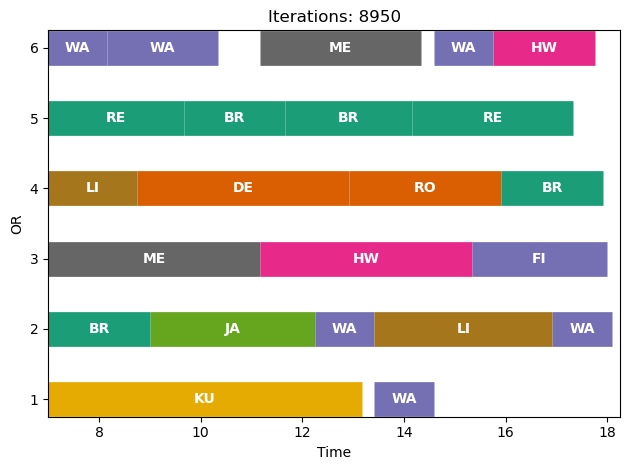

In [5]:
cbc_path = "C:\\Program Files\\Cbc-releases.2.10.8-w64-msvc16-md\\bin\\cbc.exe"
scheduler.solve(solver_name="cbc", solver_path=cbc_path, options=options)

In [113]:
scheduler._generate_disjunctions_sur()

[(0, 4, 1, 1),
 (0, 4, 1, 2),
 (0, 4, 1, 3),
 (0, 4, 1, 4),
 (0, 4, 1, 5),
 (0, 4, 1, 6),
 (0, 4, 2, 2),
 (0, 4, 2, 3),
 (0, 4, 2, 4),
 (0, 4, 2, 5),
 (0, 4, 2, 6),
 (0, 4, 3, 3),
 (0, 4, 3, 4),
 (0, 4, 3, 5),
 (0, 4, 3, 6),
 (0, 4, 4, 4),
 (0, 4, 4, 5),
 (0, 4, 4, 6),
 (0, 4, 5, 5),
 (0, 4, 5, 6),
 (0, 4, 6, 6),
 (0, 5, 1, 1),
 (0, 5, 1, 2),
 (0, 5, 1, 3),
 (0, 5, 1, 4),
 (0, 5, 1, 5),
 (0, 5, 1, 6),
 (0, 5, 2, 2),
 (0, 5, 2, 3),
 (0, 5, 2, 4),
 (0, 5, 2, 5),
 (0, 5, 2, 6),
 (0, 5, 3, 3),
 (0, 5, 3, 4),
 (0, 5, 3, 5),
 (0, 5, 3, 6),
 (0, 5, 4, 4),
 (0, 5, 4, 5),
 (0, 5, 4, 6),
 (0, 5, 5, 5),
 (0, 5, 5, 6),
 (0, 5, 6, 6),
 (0, 6, 1, 1),
 (0, 6, 1, 2),
 (0, 6, 1, 3),
 (0, 6, 1, 4),
 (0, 6, 1, 5),
 (0, 6, 1, 6),
 (0, 6, 2, 2),
 (0, 6, 2, 3),
 (0, 6, 2, 4),
 (0, 6, 2, 5),
 (0, 6, 2, 6),
 (0, 6, 3, 3),
 (0, 6, 3, 4),
 (0, 6, 3, 5),
 (0, 6, 3, 6),
 (0, 6, 4, 4),
 (0, 6, 4, 5),
 (0, 6, 4, 6),
 (0, 6, 5, 5),
 (0, 6, 5, 6),
 (0, 6, 6, 6),
 (0, 9, 1, 1),
 (0, 9, 1, 2),
 (0, 9, 1, 3),
 (0, 9, 1,

In [65]:
23*11
# len(a)

253

In [62]:
times=[1.9, 10, 20, 34.87, 35.02, 40]
cnt=0
for x in times:
# for x in range(1,130,10):
    options = {"seconds": x}
    scheduler.solve(solver_name="cbc", solver_path=cbc_path, options=options)
    plt.savefig('test'+str(cnt)+'.png')
    cnt+=1

In [42]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='C:/Users/lliu10/OneDrive - Inside MD Anderson/Documents/GitHub/theatre-scheduling/modelling'
fps=1

image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_video.mp4')

Moviepy - Building video my_video.mp4.
Moviepy - Writing video my_video.mp4



Moviepy - Done !
Moviepy - video ready my_video.mp4
